# ✈️ 航空客户信息挖掘实验报告
本实验旨在通过航空客户的飞行与消费行为，完成以下三个目标：

1. 客户流失预测（有监督分类）
2. 客户细分（无监督聚类）
3. 客户价值评估（RFM模型）

数据文件为 Excel 格式（`.xls`），共包含约 63 个特征，62988 条样本。

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


In [30]:
def load_and_clean_data(filepath):
    df = pd.read_excel(filepath)  # 读取 .xlsx文件
    print("原始数据维度：", df.shape)
    
    threshold = len(df) * 0.3
    df.dropna(thresh=threshold, axis=1, inplace=True)
    df.fillna(df.median(numeric_only=True), inplace=True)
    return df


In [31]:
def define_churn(df):
    for col in ['DAYS_FROM_LAST_TO_END', 'MAX_FLIGHT_INTERVAL', 'AVG_FLIGHT_INTERVAL']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].median(), inplace=True)
    
    df['是否流失'] = (
        (df['DAYS_FROM_LAST_TO_END'] > df['MAX_FLIGHT_INTERVAL']) |
        (df['DAYS_FROM_LAST_TO_END'] > 3 * df['AVG_FLIGHT_INTERVAL'])
    ).astype(int)
    print("✅ 客户流失标签构造完成，流失客户数：", df['是否流失'].sum())
    return df


In [32]:
def extract_features(df):
    keywords = ['FLIGHT', 'POINT', 'EXPENSE', 'SUM', 'COUNT', 'DISCOUNT', 'Ration']
    num_features = df.select_dtypes(include=np.number).columns.tolist()
    selected = [col for col in num_features if any(key in col.upper() for key in keywords)]
    
    # 打印选中的特征列名
    print("Selected features before scaling:")
    print(selected)
    
    features = df[selected].copy()
    features.fillna(0, inplace=True)

    scaler = StandardScaler()
    features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    
    # 打印标准化后的特征列名
    # print("\nFeatures after scaling:")
    # print(features_scaled.columns.tolist())
    
    return features_scaled

In [33]:
def churn_prediction(df, features_scaled):
    if '是否流失' not in df.columns:
        print("未发现 '是否流失' 字段，跳过流失预测")
        return
    
    X = features_scaled
    y = df['是否流失']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("🎯 客户流失预测报告：")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    with open("churn_report.txt", "w", encoding="utf-8") as f:
        f.write("混淆矩阵：\n")
        f.write(str(confusion_matrix(y_test, y_pred)))
        f.write("\n\n分类报告：\n")
        f.write(classification_report(y_test, y_pred))
    print("✅ 已保存 churn_report.txt")


In [34]:
def customer_segmentation(features_scaled, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_clustered = features_scaled.copy()
    df_clustered['cluster'] = kmeans.fit_predict(features_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=features_scaled.iloc[:, 0],
        y=features_scaled.iloc[:, 20],
        hue=df_clustered['cluster'],
        palette='Set2'
    )
    plt.title("Results of customer clustering")
    plt.xlabel(features_scaled.columns[0])
    plt.ylabel(features_scaled.columns[1])
    plt.savefig("customer_clusters.png", dpi=300, bbox_inches='tight')
    print("✅ 已保存聚类图 customer_clusters.png")
    return df_clustered


In [35]:
def customer_value_rfm(df):
    if 'LAST_FLIGHT_DATE' not in df.columns:
        print("未找到 LAST_FLIGHT_DATE 字段，跳过RFM分析")
        return

    df['LAST_FLIGHT_DATE'] = pd.to_datetime(df['LAST_FLIGHT_DATE'], errors='coerce')
    df['当前时间'] = pd.Timestamp("2025-06-21")
    
    rfm = pd.DataFrame()
    rfm['Recency'] = (df['当前时间'] - df['LAST_FLIGHT_DATE']).dt.days
    rfm['Frequency'] = df['AVG_FLIGHT_COUNT']
    rfm['Monetary'] = df['EXPENSE_SUM_YR_1']

    rfm = rfm.fillna(rfm.median(numeric_only=True))
    rfm_score = rfm.rank(method='dense', ascending=False)
    df['RFM得分'] = (rfm_score['Recency'] + rfm_score['Frequency'] + rfm_score['Monetary'])

    df[['RFM得分']].to_csv("rfm_scores.csv", index=False)
    print("✅ RFM得分已保存至 rfm_scores.csv")


In [36]:
def run_all(filepath):
    df = load_and_clean_data(filepath)
    df = define_churn(df)
    features_scaled = extract_features(df)

    churn_prediction(df, features_scaled)
    clustered_df = customer_segmentation(features_scaled)
    customer_value_rfm(df)

    df.to_csv("labeled_airline_data.csv", index=False)
    clustered_df.to_csv("clustered_airline_data.csv", index=False)
    print("✅ 所有处理完毕，数据已保存")
   

原始数据维度： (62988, 63)
✅ 客户流失标签构造完成，流失客户数： 26953
Selected features before scaling:
['FLIGHT_COUNT', 'FLIGHT_COUNT_QTR_1', 'FLIGHT_COUNT_QTR_2', 'FLIGHT_COUNT_QTR_3', 'FLIGHT_COUNT_QTR_4', 'FLIGHT_COUNT_QTR_5', 'FLIGHT_COUNT_QTR_6', 'FLIGHT_COUNT_QTR_7', 'FLIGHT_COUNT_QTR_8', 'FACD_CLASS_COUNT', 'BASE_POINTS_SUM', 'BASE_POINTS_SUM_QTR_1', 'BASE_POINTS_SUM_QTR_2', 'BASE_POINTS_SUM_QTR_3', 'BASE_POINTS_SUM_QTR_4', 'BASE_POINTS_SUM_QTR_5', 'BASE_POINTS_SUM_QTR_6', 'BASE_POINTS_SUM_QTR_7', 'BASE_POINTS_SUM_QTR_8', 'ELITE_POINTS_SUM_YR_1', 'ELITE_POINTS_SUM_YR_2', 'EXPENSE_SUM_YR_1', 'EXPENSE_SUM_YR_2', 'SEG_KM_SUM', 'AVG_FLIGHT_COUNT', 'AVG_BASE_POINTS_SUM', 'AVG_FLIGHT_INTERVAL', 'MAX_FLIGHT_INTERVAL', 'MILEAGE_IN_COUNT', 'ADD_POINTS_SUM_YR_1', 'ADD_POINTS_SUM_YR_2', 'EXCHANGE_COUNT', 'avg_discount', 'P1Y_Flight_Count', 'L1Y_Flight_Count', 'P1Y_BASE_POINTS_SUM', 'L1Y_BASE_POINTS_SUM', 'ELITE_POINTS_SUM', 'ADD_POINTS_SUM', 'Eli_Add_Point_Sum', 'L1Y_ELi_Add_Points', 'Points_Sum', 'L1Y_Points_Su

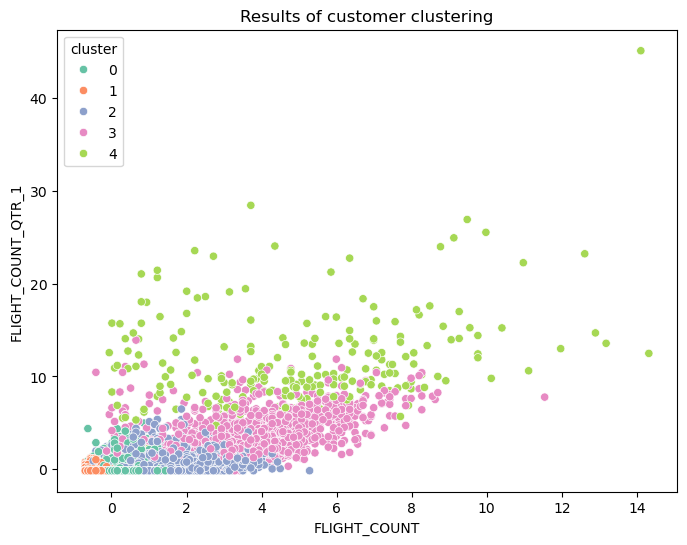

In [37]:
run_all("airline_data.xlsx")
